In [1]:
import os  # noqa
import sys  # noqa

proj_root = os.path.dirname(os.getcwd())
sys.path.append(proj_root)

OBJ_NAME = "mustard_bottle"
VIDEO_NAME = "mustard0"


video_dir = os.path.join(proj_root, "data", "inputs", VIDEO_NAME)
tracker_result_video = os.path.join(video_dir)
obj_dir = os.path.join(proj_root, "data", "objects", OBJ_NAME)

In [2]:
import cv2
import matplotlib.pyplot as plt
import torch
from posingpixels.cotracker import CoMeshTracker
from posingpixels.utils.geometry import apply_pose_to_points
from posingpixels.datasets import YCBinEOATDataset, load_video_images
from pytorch3d.ops.perspective_n_points import efficient_pnp
from posingpixels.utils.cotracker import visualize_results
from posingpixels.utils.evaluation import get_gt_tracks

from pytorch3d.renderer import PerspectiveCameras


from posingpixels.utils.cotracker import unscale_by_crop

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [3]:
dataset = YCBinEOATDataset(video_dir, obj_dir)
tracker = CoMeshTracker(
    dataset,
    # support_grid=10,
    offline=False,
    # crop=False,
    # visible_background=True,
    # downcast=True,
    # better_initialization=False,
    # offline_limit=500,
    interpolation_steps=15,
    device=device,
)

In [4]:
pred_tracks, pred_visibility, pred_confidence = tracker()

Preparing images for CoTracker: 100%|██████████| 752/752 [00:17<00:00, 42.15it/s]
Processing batches: 94it [00:22,  4.23it/s]                        


In [5]:
video = load_video_images(tracker.cotracker_input_dir, limit=tracker.limit)
init_video = load_video_images(tracker.init_video_dir, limit=tracker.limit, file_type="jpg")
video_original = load_video_images(tracker.dataset.video_rgb_dir, limit=tracker.limit)

In [6]:
visualize_results(
    video,
    pred_tracks,
    pred_visibility,
    pred_confidence,
    tracker_result_video,
    num_of_main_queries=tracker.object_query_points_num,
)

gt_tracks, gt_visibility = get_gt_tracks(tracker)
visualize_results(
    video,
    torch.tensor(gt_tracks).to(device).unsqueeze(0).float(),
    torch.tensor(gt_visibility).to(device).unsqueeze(0).float(),
    torch.ones_like(torch.tensor(gt_visibility).to(device)).unsqueeze(0).float(),
    tracker_result_video,
    num_of_main_queries=tracker.object_query_points_num,
    filename="gt_video",
)

pred_tracks_original = unscale_by_crop(
    pred_tracks[0],
    torch.tensor(tracker.bboxes).to(device),
    torch.tensor(tracker.scaling).to(device),
).unsqueeze(0)

full_video = torch.cat([init_video, video_original], dim=1)
visualize_results(
    full_video,
    pred_tracks_original,
    pred_visibility,
    pred_confidence,
    tracker_result_video,
    num_of_main_queries=tracker.object_query_points_num,
    filename="original",
)

gt_tracks_original, gt_visibility_original = get_gt_tracks(tracker, crop=False)
visualize_results(
    full_video,
    torch.tensor(gt_tracks_original).to(device).unsqueeze(0).float(),
    torch.tensor(gt_visibility_original).to(device).unsqueeze(0).float(),
    torch.ones_like(torch.tensor(gt_visibility_original).to(device)).unsqueeze(0).float(),
    tracker_result_video,
    num_of_main_queries=tracker.object_query_points_num,
    filename="gt_original",
)

Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/video.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/gt_video.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/original.mp4
Video saved to /home/joao/Documents/repositories/GSPose/data/inputs/mustard0/gt_original.mp4


In [7]:
from posingpixels.utils.evaluation import compute_tapvid_metrics
import numpy as np


query_points = tracker.query_2d_points[np.newaxis, :]
print(query_points.shape)
gt_occluded = (gt_visibility.T < 0.5)[np.newaxis, :]
print(gt_occluded.shape)
gt_tracks_ = np.transpose(gt_tracks[np.newaxis, :], (0, 2, 1, 3))
print(gt_tracks_.shape)
pred_visibility_ = pred_visibility.permute(0, 2, 1).cpu().numpy()
pred_occluded = pred_visibility_ < 0.5
print(pred_occluded.shape)
pred_tracks_ = pred_tracks.permute(0, 2, 1, 3).cpu().numpy()
print(pred_tracks_.shape)
pred_confidence_ = pred_confidence.cpu().permute(0, 2, 1).numpy()
print(pred_confidence_.shape)

# We are only interested in evaluating points where confidence * visibility > 0.6 (B x N x T)
threshold = 0.9
evaluation_points = (pred_confidence_ * pred_visibility_ > threshold)
# evaluation_points = np.ones_like(pred_confidence_, dtype=bool)

metrics = compute_tapvid_metrics(
    query_points=query_points,
    gt_occluded=gt_occluded,
    gt_tracks=gt_tracks_,
    pred_occluded=pred_occluded,
    pred_tracks=pred_tracks_,
    query_mode='first',
    evaluation_points=evaluation_points,
)
# Print the following metrics
print("occlusion_accuracy", metrics["occlusion_accuracy"])
print("average_jaccard", metrics["average_jaccard"])
print("average_pts_within_thresh", metrics["average_pts_within_thresh"])
print("pts_within_1", metrics["pts_within_1"])
print("jaccard_1", metrics["jaccard_1"])
print("pts_within_2", metrics["pts_within_2"])
print("jaccard_2", metrics["jaccard_2"])
print("pts_within_4", metrics["pts_within_4"])
print("jaccard_4", metrics["jaccard_4"])
print("pts_within_8", metrics["pts_within_8"])
print("jaccard_8", metrics["jaccard_8"])
print("pts_within_16", metrics["pts_within_16"])
print("jaccard_16", metrics["jaccard_16"])
print(metrics.keys())

(1, 202, 3)
(1, 202, 752)
(1, 202, 752, 2)
(1, 202, 752)
(1, 202, 752, 2)
(1, 202, 752)
occlusion_accuracy [0.95471962]
average_jaccard [0.19091165]
average_pts_within_thresh [0.26061729]
pts_within_1 [0.00950599]
jaccard_1 [0.00466455]
pts_within_2 [0.02780376]
jaccard_2 [0.0137668]
pts_within_4 [0.08392144]
jaccard_4 [0.04274059]
pts_within_8 [0.34580393]
jaccard_8 [0.20321994]
pts_within_16 [0.83605136]
jaccard_16 [0.69016635]
dict_keys(['occlusion_accuracy_over_time', 'occlusion_accuracy', 'time_pts_within_1', 'per_point_pts_within_1', 'pts_within_1', 'time_jaccard_1', 'per_point_jaccard_1', 'jaccard_1', 'time_pts_within_2', 'per_point_pts_within_2', 'pts_within_2', 'time_jaccard_2', 'per_point_jaccard_2', 'jaccard_2', 'time_pts_within_4', 'per_point_pts_within_4', 'pts_within_4', 'time_jaccard_4', 'per_point_jaccard_4', 'jaccard_4', 'time_pts_within_8', 'per_point_pts_within_8', 'pts_within_8', 'time_jaccard_8', 'per_point_jaccard_8', 'jaccard_8', 'time_pts_within_16', 'per_point_

/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:90: RuntimeWarning: invalid value encountered in divide
  occ_acc_ = np.sum(np.equal(pred_occluded, gt_occluded) & evaluation_points, axis=1) / np.sum(evaluation_points, axis=1)
/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:128: RuntimeWarning: invalid value encountered in divide
  frac_correct_time_ = np.sum(count_correct_, axis=1) / np.sum(count_visible_points_, axis=1)
/home/joao/Documents/repositories/GSPose/posingpixels/utils/evaluation.py:157: RuntimeWarning: invalid value encountered in divide
  jaccard_time_ = np.sum(true_positives_, axis=1) / (np.sum(gt_positives_ + false_positives_, axis=1))


Text(0.5, 1.0, 'Number of points considered per time step with visibility * confidence > 0.9')

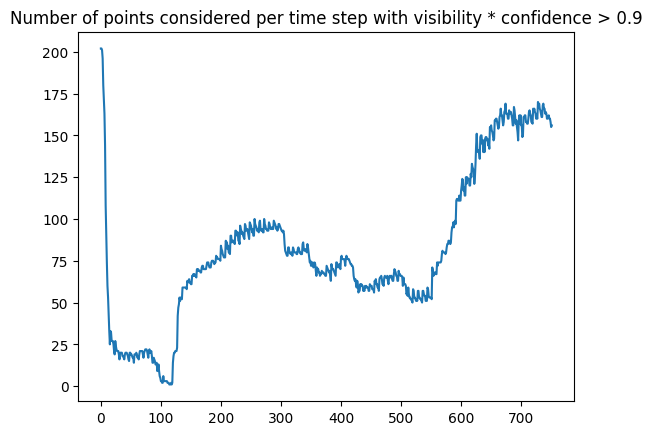

In [8]:
# How many points are being evaluated per time step?
evaluation_points.shape
plt.plot(evaluation_points.sum(axis=(0, 1)))
plt.title(f"Number of points considered per time step with visibility * confidence > {threshold}")

Text(0, 0.5, 'Value')

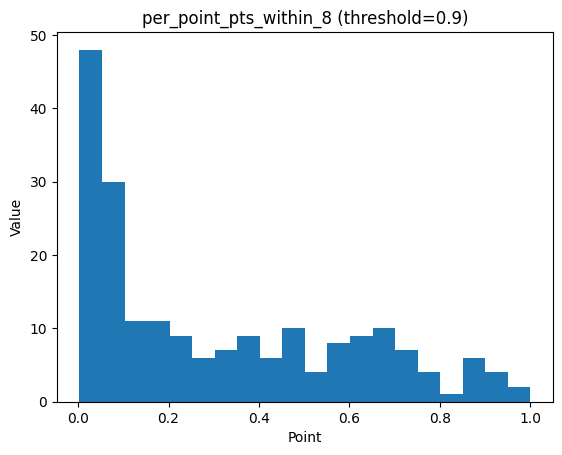

In [9]:
metric_name = 'per_point_pts_within_8'
values = metrics[metric_name][0]
# If we're doing a time metric, plot a line plot
# If we're doing a per point metric, plot distribution of values
plt.plot(values) if 'time' in metric_name else plt.hist(values, bins=20)
# Plot vertical line on self.interpolation_steps
plt.axvline(tracker.interpolation_steps, color='r', linestyle='--') if 'time' in metric_name else None
plt.title(f'{metric_name} (threshold={threshold})')
plt.xlabel('Frame' if 'time' in metric_name else 'Point')
plt.ylabel('Value')

In [ ]:
import mediapy
from posingpixels.utils.geometry import apply_pose_to_points_batch, render_points_in_2d, render_points_in_2d_batch
from posingpixels.visualization import overlay_bounding_box_on_video


def solve_pnp(points_3d: torch.Tensor, points_2d: torch.Tensor, K: torch.Tensor, image_size: torch.Tensor, device: torch.device):
    if len(points_2d.shape) == 2:
        points_2d = points_2d.clone().unsqueeze(0)
    B, N, _ = points_2d.shape
    if len(points_3d.shape) == 2:
        points_3d = points_3d.clone().unsqueeze(0).repeat(B, 1, 1)
    if len(image_size.shape) == 1:
        image_size = image_size.unsqueeze(0).repeat(B, 1)
    if len(K.shape) == 2:
        K = K[:3, :3].clone().unsqueeze(0).repeat(B, 1, 1)
    
    p3d = points_3d
    p2d_h = torch.cat((points_2d[..., :2], torch.ones(B, N, 1, device=device).to(device)), dim=-1)
    # Flip focal length (because of the way pytorch3d is implemented)
    # K[:, 0, 0] = -K[:, 0, 0]; K[:, 1, 1] = -K[:, 1, 1]
    p_inv = torch.inverse(K).transpose(1, 2)
    p2d_uncal = torch.matmul(p2d_h, p_inv)
    transform = efficient_pnp(p3d, p2d_uncal[..., :2])
    
    return transform
    
considered_limit = tracker.limit
x = (
    torch.tensor(tracker.unposed_3d_points, dtype=torch.float32)
    .to(device)
    .unsqueeze(0)
    .repeat(considered_limit, 1, 1)
)
gt_poses = torch.tensor(tracker.get_gt_poses()[:considered_limit]).float().to(device)
gt_posed_x = apply_pose_to_points_batch(x, gt_poses[:, :3, :3], gt_poses[:, :3, 3])
y_gt = render_points_in_2d_batch(gt_posed_x, torch.tensor(tracker.K[:3, :3]).float().to(device))

y = pred_tracks_original.detach().clone().squeeze(0)[:considered_limit]

results = solve_pnp(x, y, torch.tensor(tracker.K).to(device).float(), torch.tensor((tracker.H, tracker.W)).to(device), device)
result_poses = torch.eye(4).unsqueeze(0).to(device).repeat(considered_limit, 1, 1)
result_poses[:, :3, :3] = results.R.transpose(1, 2)
result_poses[:, :3, 3] = results.T

camKs = torch.tensor(tracker.K[np.newaxis, :].repeat(considered_limit, axis=0)).float()
print(result_poses[0])
print(dataset.bbox)
video_permuted = full_video[0].permute(0, 2, 3, 1)
bbox_video = overlay_bounding_box_on_video(video_permuted[:considered_limit].detach().cpu().numpy(), dataset.bbox.float(), camKs, gt_poses.detach().cpu().numpy())
bbox_video = overlay_bounding_box_on_video(bbox_video, dataset.bbox.float(), camKs, result_poses.detach().cpu().numpy(), color=(255, 0, 0))
print(bbox_video.shape)
print(dataset.get_mesh().bounds)
mediapy.show_video(bbox_video[:considered_limit], fps=15)
# for i in range(15):
#     gt_pose = torch.tensor(tracker.get_gt_pose(i)).float().to(device)
#     pred_pose = torch.eye(4).to(device)
#     pred_pose[:3, :3] = results.R[i].T
#     pred_pose[:3, 3] = results.T[i]
#     rgb, _ = tracker.dataset.render_mesh_at_pose(pred_pose.detach().cpu().numpy())
#     rgb_gt, _ = tracker.dataset.render_mesh_at_pose(gt_pose.detach().cpu().numpy())
    
#     rgb_avg = cv2.addWeighted(rgb, 0.5, rgb_gt, 0.5, 0)
    
#     plt.imshow(rgb_avg)
#     plt.show()

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/pytorch3d/ops/perspective_n_points.py:160: UserWarning: 
EPnP: 0.50% points have z<0.
  warnings.warn("\nEPnP: %2.2f%% points have z<0." % (neg_rate * 100.0))
/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/pytorch3d/ops/perspective_n_points.py:160: UserWarning: 
EPnP: 0.06% points have z<0.
  warnings.warn("\nEPnP: %2.2f%% points have z<0." % (neg_rate * 100.0))


tensor([[-1.0000e+00,  1.8775e-05,  3.9800e-06, -4.6195e-07],
        [-4.0308e-06, -8.7740e-06, -1.0000e+00, -1.0245e-08],
        [-1.8567e-05, -1.0000e+00,  8.6753e-06,  1.9646e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0')
tensor([[-0.0486, -0.0333, -0.0957],
        [ 0.0486, -0.0333, -0.0957],
        [ 0.0486,  0.0333, -0.0957],
        [-0.0486,  0.0333, -0.0957],
        [-0.0486, -0.0333,  0.0957],
        [ 0.0486, -0.0333,  0.0957],
        [ 0.0486,  0.0333,  0.0957],
        [-0.0486,  0.0333,  0.0957]], dtype=torch.float64)
(752, 480, 640, 3)
[[-0.049815 -0.035766 -0.083861]
 [ 0.047336  0.030853  0.107547]]


In [11]:
# for i in range(15):
#     pytorch_K = torch.eye(4)
#     pytorch_K[:3, :3] = torch.tensor(tracker.K)
#     pytorch_K = pytorch_K.to(device).float()
#     f = torch.tensor([pytorch_K[0, 0], pytorch_K[1, 1]]).to(device).unsqueeze(0)
#     p = torch.tensor([pytorch_K[0, 2], pytorch_K[1, 2]]).to(device).unsqueeze(0)
#     camera = PerspectiveCameras(
#         device=device,
#         R=torch.eye(3).unsqueeze(0),
#         T=torch.tensor([0, 0, 0.0]).unsqueeze(0),
#         # K=pytorch_K.unsqueeze(0),
#         focal_length=f,
#         principal_point=p,
#         in_ndc=False,
#         image_size=torch.tensor((tracker.H, tracker.W)).to(device).unsqueeze(0),
#     )
#     gt_pose = torch.tensor(tracker.get_gt_pose(i)).float().to(device)
#     posed_points = apply_pose_to_points(x[i], gt_pose[:3, :3], gt_pose[:3, 3])
#     # rendered_points = camera.transform_points_screen(posed_points.unsqueeze(0))
#     rendered_points = render_points_in_2d(posed_points, pytorch_K[:3, :3]).unsqueeze(0)
#     # rendered_points_alternative = torch.tensor([tracker.W, tracker.H]).to(device) - rendered_points_alternative
#     # assert torch.allclose(rendered_points[..., :2], rendered_points_alternative[..., :2])
#     num_batch = rendered_points.shape[0]
#     num_pts = rendered_points.shape[1]

#     p3d = posed_points
#     p2d_h = torch.cat(
#         (rendered_points[..., :2], torch.ones(num_batch, num_pts, 1).to(device)), dim=-1
#     )
#     # pytorch_K[0, 0] = -pytorch_K[0, 0]
#     # pytorch_K[1, 1] = -pytorch_K[1, 1]
#     p_inv = torch.inverse(pytorch_K[:3, :3]).T
#     p2d_uncal = torch.matmul(p2d_h, p_inv.unsqueeze(0))
#     transform = efficient_pnp(x[i].unsqueeze(0), p2d_uncal[..., :2])

#     print(transform.R, transform.T)

#     pred_pose = torch.eye(4).to(device)
#     pred_pose[:3, :3] = transform.R.squeeze().T
#     pred_pose[:3, 3] = transform.T.squeeze()
#     rgb, _ = tracker.dataset.render_mesh_at_pose(pred_pose.detach().cpu().numpy())
#     rgb_gt, _ = tracker.dataset.render_mesh_at_pose(gt_pose.detach().cpu().numpy())
#     rgb_avg = cv2.addWeighted(rgb, 0.5, rgb_gt, 0.5, 0)
#     plt.imshow(rgb_avg)
#     # plt.imshow(rgb)
#     plt.show()